In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

from factor_vae import FactorVAE, Discriminator
from datasets import train_test_random_split, load_dsprites, CustomDataset
from train_factor_vae import train_factor_VAE

In [2]:
dataset = load_dsprites("../datasets/dsprites.npz",False)
imgs = dataset["imgs"]

In [3]:
data = CustomDataset(imgs,1000)

In [4]:
data_train, data_test = train_test_random_split(data, 0.8)

Length of training data : 800
Length of testing data : 200


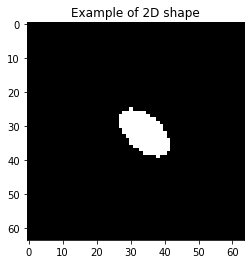

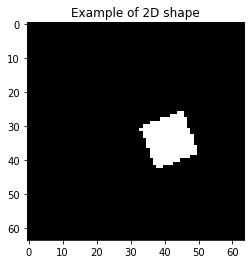

In [5]:
print("Length of training data :",len(data_train))
print("Length of testing data :",len(data_test))

for i in [0, -1]:
    im, _ = data_train[i]
    im = im.squeeze()
    plt.imshow(im, cmap='Greys_r')
    plt.title("Example of 2D shape")
    plt.show()

In [6]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False)

In [7]:
model = FactorVAE()
discriminator = Discriminator(nb_layers=4,hidden_dim=1000)
VAE_optimizer = torch.optim.Adam(model.parameters(), betas=(0.9,0.999), lr=1e-4)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), betas=(0.9,0.999), lr=1e-4)
gamma = 0
nb_epochs = 5


train_factor_VAE(model, discriminator, VAE_optimizer, discriminator_optimizer, gamma, nb_epochs, train_loader, True)

Epoch 0:
training vae loss of 2890.6821875
training recon loss of 2890.6671875
training kld loss of 0.01514487385749817
training TC loss of 0.0045524793863296505
training discriminator loss of 0.6938858795166015
Epoch 1:
training vae loss of 2862.61
training recon loss of 2862.5821875
training kld loss of 0.027762007713317872
training TC loss of 0.00240234911441803
training discriminator loss of 0.6945362854003906
Epoch 2:
training vae loss of 2779.1578125
training recon loss of 2778.1815625
training kld loss of 0.976167221069336
training TC loss of -0.0055914664268493655
training discriminator loss of 0.698239517211914
Epoch 3:
training vae loss of 2156.16734375
training recon loss of 2035.0240625
training kld loss of 121.14328125
training TC loss of -0.17175464630126952
training discriminator loss of 0.7180226135253907
Epoch 4:
training vae loss of 1355.99328125
training recon loss of 1257.50765625
training kld loss of 98.48560546875
training TC loss of 0.07149678230285644
training d

NameError: name 'train_vae_losses' is not defined

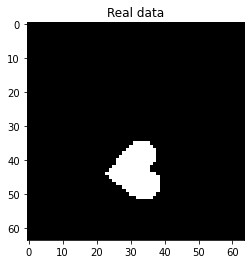

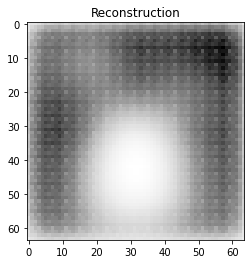

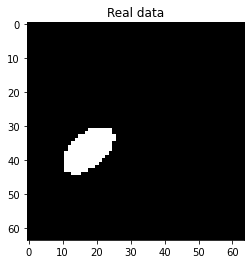

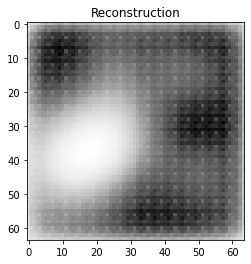

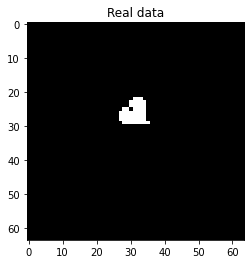

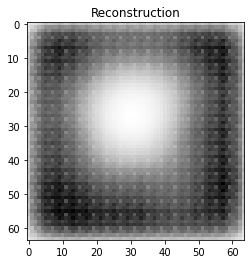

In [142]:
with torch.no_grad():
    for i in [1000,15,20]:
        data, _ = data_test[i]
        data = data.unsqueeze(1)
        recon, mu, logvar, z = model(data)
        data = data.squeeze()
        recon = recon.squeeze()
        plt.imshow(data, cmap='Greys_r')
        plt.title("Real data")
        plt.show()
        plt.imshow(recon, cmap='Greys_r')
        plt.title("Reconstruction")
        plt.show()

In [ ]:
latent_sizes = dataset['metadata'][()]['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1, fixed = None):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latent_sizes):
        if fixed == lat_i:
            fixed_value = np.random.randint(lat_size, size=1)
            samples[:, lat_i] = np.full(size, fixed_value)
        else:
            samples[:, lat_i] = np.random.randint(lat_size, size=size)
    return samples

latents_sampled = sample_latent(size=100)
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

In [ ]:
latent_values = dataset["latent_values"]
global_vars = np.var(latent_values, axis = 1)
print(global_vars)

In [ ]:
def FactorVAE_entanglement_metric(nb_samples,sample_size):
    score = 0
    for i in range(nb_samples):
        k = np.random.randint(len(latent_sizes)-1)+1
        latents_sampled = sample_latent(size=sample_size)
        indices_sampled = latent_to_index(latents_sampled)
        imgs_sampled = imgs[indices_sampled]
        latents_rep = []
        for data in imgs_sampled:
            data = torch.from_numpy(data).unsqueeze(1).float()
            recon, mu, logvar, z = model(data)
            z = z.squeeze()
            latents_rep.append(z)
        latents_var = np.var(latents_rep, axis = 1) 
        latents_var_normalized = latents_var.div(global_vars)
        kprime = np.argmin(latents_var_normalized)+1
        score = score + int(k == kprime)
    return score/nb_samples